# MNIST Digit Classification with K-Nearest Neighbors
### Achieving 97% Accuray Through Hyperparameter Optimization

## 1. Introduction and Objectives
In this notebook, we will build a K-Nearest (KNN) classifier for the famous MNIST handwritten digit dataset. Our goal is to achieve **over 97% accuracy** on the test set by finding iptimal hyperparameters through grid search.

#### Why KNN for MINST?
- KNN is a simple, intuitive algorithm that works well for image classification
- It performs surprisingly well on MNIST despite its simplicity
- No training phase required - it's lazy learning algorithm
- Works well with high-demensional data like flattened images

## 2. Import Libraries and Setup

In [132]:
# data manipultion and numerical computing
import numpy as np
import pandas as pd

In [133]:
#  machine learning (scikit-learn)
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [134]:
# visualization
import matplotlib.pyplot as plt
import seaborn as sns


In [135]:
# utility and ignore warnings
from time import time
import warnings
warnings.filterwarnings('ignore')


In [136]:
# set random seed for reproductibility
np.random.seed(77)

## 3. Load and Explore the MNIST Dataset

In [137]:
# load MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
print("Data loaded successfully.")


Data loaded successfully.


In [138]:
# extract features and labels
X, y = mnist.data, mnist.target.astype(int)

print(f"Dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")

print(f"Number of classes: {len(np.unique(y))}")
print(f"Clases: {np.unique(y)}")


Dataset shape: (70000, 784)
Labels shape: (70000,)
Number of classes: 10
Clases: [0 1 2 3 4 5 6 7 8 9]


## 4. Data Preprocessing and Visualization


In [139]:
# normalize pixel values to 0-1 range
X = X / 255.0
print("Pixel values normalized to 0-1 range.")

# check
print(f"Min pixel value: {X.min()}")
print(f"Max pixel value: {X.max()}")


Pixel values normalized to 0-1 range.
Min pixel value: 0.0
Max pixel value: 1.0


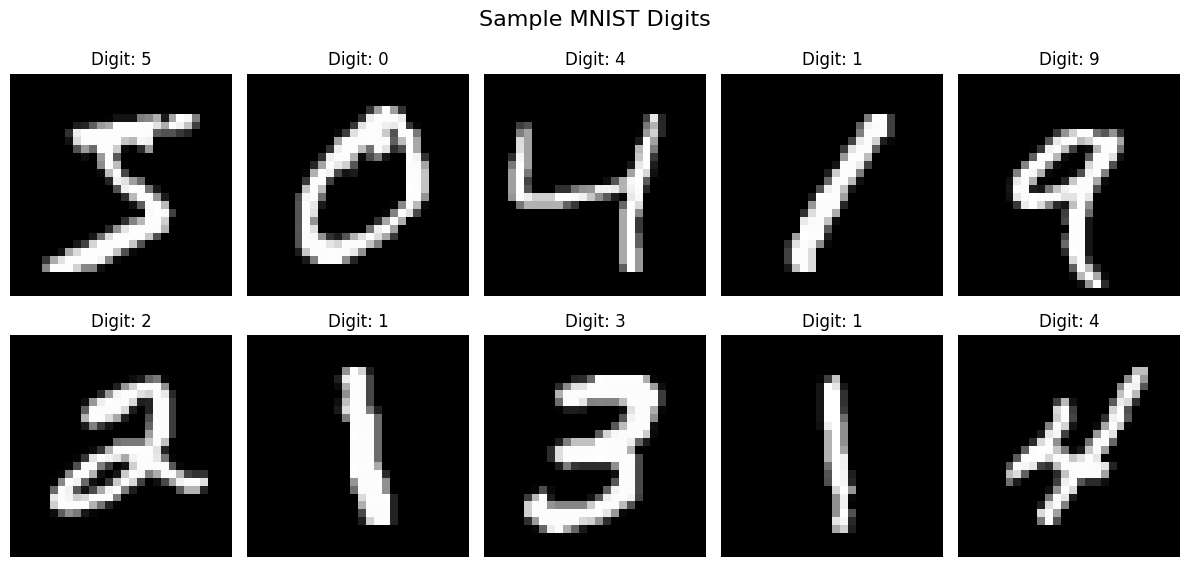

In [140]:
# visualize sample digit images
fig, axes = plt.subplots(2,5, figsize=(12,6))
fig.suptitle('Sample MNIST Digits', fontsize=16)

for i, ax in enumerate(axes.flat):
    # reshaping the flattened image back to 28x28
    image = X[i].reshape(28,28)
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Digit: {y[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

###### Note:
- `axes` is a 2x5 array of subplots --> 10 plots total.
- `axes.flat` gives us a 1D iteratir over all 10 subplot axes.
-  `enumerate(axes.flat)` assigns:
    - `i` --> the indes of the subplot (0 through 9)
    - `ax` --> the subplot ibject itself

## 5. Dataset Splitting Strategy
For MNIST, we'll a strategy approach to handle the large dataset size:

In [141]:
# MNIST is large (70,000 samples), so we'll use a subset for faster computation
# while still maintaining good performance

# first, let's see the distribution
unique, counts = np.unique(y, return_counts=True)
print("Class distribution in the dataset:")

for digit, count in zip(unique, counts):
    print(f"Digit {digit}: {count} samples")

Class distribution in the dataset:
Digit 0: 6903 samples
Digit 1: 7877 samples
Digit 2: 6990 samples
Digit 3: 7141 samples
Digit 4: 6824 samples
Digit 5: 6313 samples
Digit 6: 6876 samples
Digit 7: 7293 samples
Digit 8: 6825 samples
Digit 9: 6958 samples


In [142]:
# using stratified sampling to get a representative subset
X_subset, _, y_subset, _ = train_test_split(X, y, train_size=50000, stratify=y, random_state=77)

print(f"\nSubset size: {X_subset.shape[0]} samples")


Subset size: 50000 samples


In [143]:
# split the subset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, stratify=y_subset, random_state=77)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features per sample: {X_train.shape[1]}")

Training set: 40000 samples
Test set: 10000 samples
Features per sample: 784


## 6. Understanding KNN Hyperparameters
Before we start the grid search, let's understand the key hyperparameters:

#### Key Hyperparameter for KNN:
**1. n_neighbors(k):** Number of nearest neighbors to consider
- too small k: high variance, sensitive to noise
- too large k: high bias, oversimplified decision boundary
- typical range: 1-20 for MNIST

**2. weights:** how to weight the neighbors
-  `uniform`: all neighbors weighted equally
-  `distance`: closer nighbors have more influence

## 7. Hyperparameter Grid Search

In [144]:
# defining hyperparameter grid 
param_grid = {
    'n_neighbors': [3,5,7,9,11,13,15],
    'weights': ['uniform', 'distance']
}

print("Parameter grid:")
print(f"n_nighbors: {param_grid['n_neighbors']}")
print(f"weights: {param_grid['weights']}")
print(f"Total combinations: {len(param_grid['n_neighbors']) * len(param_grid['weights'])}")

Parameter grid:
n_nighbors: [3, 5, 7, 9, 11, 13, 15]
weights: ['uniform', 'distance']
Total combinations: 14


In [145]:
# initialize KNN classifier

knn = KNeighborsClassifier()

#setup GridSearchCV
print("Setting up Grid Search...")
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv = 3,                 # 3-fold cross-validation
    scoring='accuracy',     # optimize for accuracy
    n_jobs=-1,              # use all available cores
    verbose=1,              # show progress
)

# perform grid search
print("Starting grid search...")
start_time = time()

grid_search.fit(X_train, y_train)

end_time = time()

print(f"Grid search completed in {end_time - start_time:.2f} seconds.")

Setting up Grid Search...
Starting grid search...
Fitting 3 folds for each of 14 candidates, totalling 42 fits
Grid search completed in 31.40 seconds.


## 8. Grid Search Results Analysis

In [146]:
# display best parameters and score
print("BEST PARAMETER")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy score: {grid_search.best_score_:.4f}")

# get the best model
best_knn = grid_search.best_estimator_
print(f"Best model: {best_knn}")

BEST PARAMETER
Best parameters: {'n_neighbors': 3, 'weights': 'distance'}
Best cross-validation accuracy score: 0.9660
Best model: KNeighborsClassifier(n_neighbors=3, weights='distance')


In [147]:
# create a comprehensive results DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# extract relevant columns
summary_df = results_df[['param_n_neighbors', 'param_weights', 'mean_test_score', 'std_test_score']].copy()
summary_df.columns = ['n_neighbors', 'weights', 'mean_cv_score', 'std_cv_score']

# sort by score
summary_df = summary_df.sort_values('mean_cv_score', ascending=False)

print("TOP 10 PARAMETER COMBINATIONS")
print(summary_df.head(10).to_string(index=False))


TOP 10 PARAMETER COMBINATIONS
 n_neighbors  weights  mean_cv_score  std_cv_score
           3 distance       0.966050      0.001357
           5 distance       0.965350      0.003044
           3  uniform       0.964575      0.001217
           7 distance       0.963625      0.002704
           5  uniform       0.963600      0.002910
           7  uniform       0.961875      0.002234
           9 distance       0.961650      0.002177
           9  uniform       0.960200      0.001993
          11 distance       0.960050      0.001930
          13 distance       0.958375      0.002267


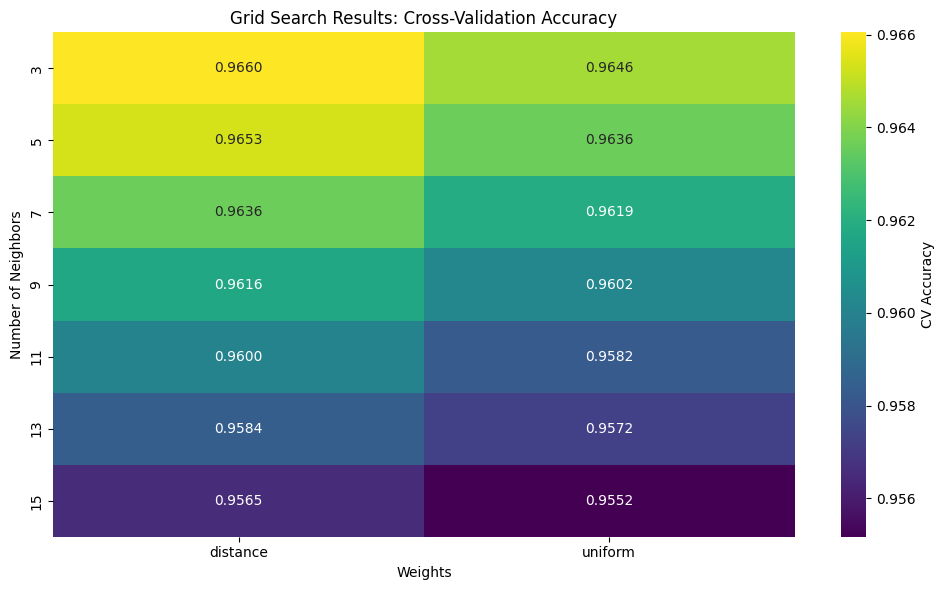

In [148]:
# visualize grid search results
pivot_table = summary_df.pivot(index='n_neighbors', columns='weights', values='mean_cv_score')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt=".4f", cbar_kws={'label':'CV Accuracy'})
plt.title('Grid Search Results: Cross-Validation Accuracy')
plt.xlabel('Weights')
plt.ylabel('Number of Neighbors')
plt.tight_layout()
plt.show()

## 9. Final Model Evaluation

In [149]:
# make predications on test set
y_pred = best_knn.predict(X_test)

# calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"FINAL RESULTS")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# check if we acheived our goal
if test_accuracy >= 0.97:
    print("SUCCESS: We achieved over 97% accuracy!")
else:
    print(f"Almost there! We achieved {test_accuracy*100:.2f}% accuracy.")

FINAL RESULTS
Test Accuracy: 0.9705 (97.05%)
SUCCESS: We achieved over 97% accuracy!


In [150]:
print("\n DETAILED CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred))


 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       986
           1       0.95      0.99      0.97      1125
           2       0.98      0.96      0.97       999
           3       0.97      0.96      0.97      1020
           4       0.98      0.97      0.97       975
           5       0.97      0.97      0.97       902
           6       0.98      0.99      0.98       982
           7       0.96      0.97      0.97      1042
           8       0.98      0.93      0.95       975
           9       0.96      0.97      0.97       994

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



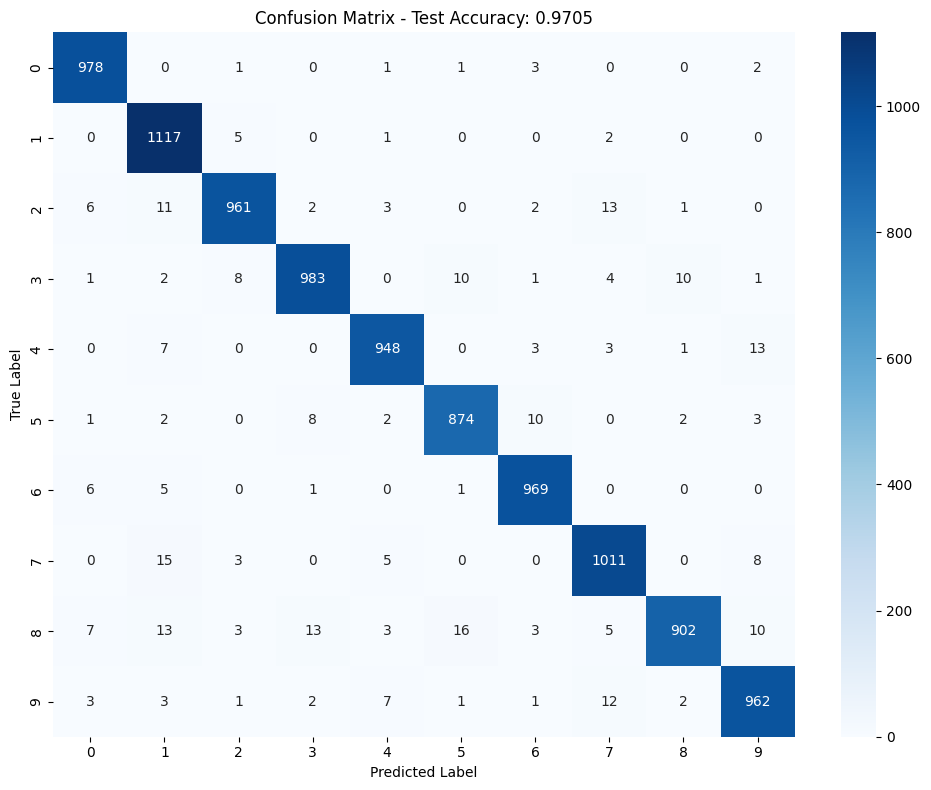

In [151]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title(f"Confusion Matrix - Test Accuracy: {test_accuracy:.4f}")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


## 10. Performance Analysis and Insights

In [152]:
# analyze per-class performance
report_dict = classification_report(y_test, y_pred, output_dict=True)

# extract per-class metrics
class_metrics = []
for digit in range(10):
    metrics = report_dict[str(digit)]
    class_metrics.append({
        'digit': digit,
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'f1-score': metrics['f1-score'],
        'support': metrics['support']
    })

class_df = pd.DataFrame(class_metrics)
print("PER-CLASS PERFORMANCE")
print(class_df.to_string(index=False))

PER-CLASS PERFORMANCE
 digit  precision   recall  f1-score  support
     0   0.976048 0.991886  0.983903    986.0
     1   0.950638 0.992889  0.971304   1125.0
     2   0.978615 0.961962  0.970217    999.0
     3   0.974232 0.963725  0.968950   1020.0
     4   0.977320 0.972308  0.974807    975.0
     5   0.967885 0.968958  0.968421    902.0
     6   0.976815 0.986762  0.981763    982.0
     7   0.962857 0.970250  0.966539   1042.0
     8   0.982571 0.925128  0.952985    975.0
     9   0.962963 0.967807  0.965379    994.0


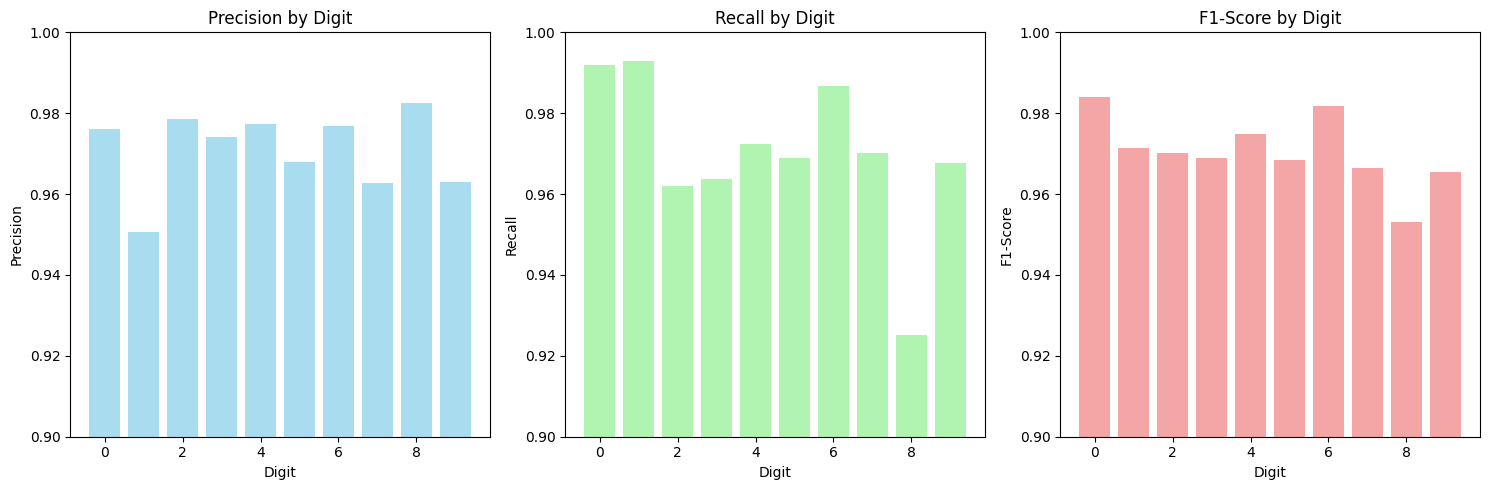

In [153]:
# Visualize per-class performance
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Precision
axes[0].bar(class_df['digit'], class_df['precision'], color='skyblue', alpha=0.7)
axes[0].set_title('Precision by Digit')
axes[0].set_xlabel('Digit')
axes[0].set_ylabel('Precision')
axes[0].set_ylim(0.9, 1.0)

# Recall
axes[1].bar(class_df['digit'], class_df['recall'], color='lightgreen', alpha=0.7)
axes[1].set_title('Recall by Digit')
axes[1].set_xlabel('Digit')
axes[1].set_ylabel('Recall')
axes[1].set_ylim(0.9, 1.0)

# F1-Score
axes[2].bar(class_df['digit'], class_df['f1-score'], color='lightcoral', alpha=0.7)
axes[2].set_title('F1-Score by Digit')
axes[2].set_xlabel('Digit')
axes[2].set_ylabel('F1-Score')
axes[2].set_ylim(0.9, 1.0)

plt.tight_layout()
plt.show()

## 11. Model Interpretation and Error Anallysis

Number of misclassified samples: 295 out of 10000
Error rate: 2.95%


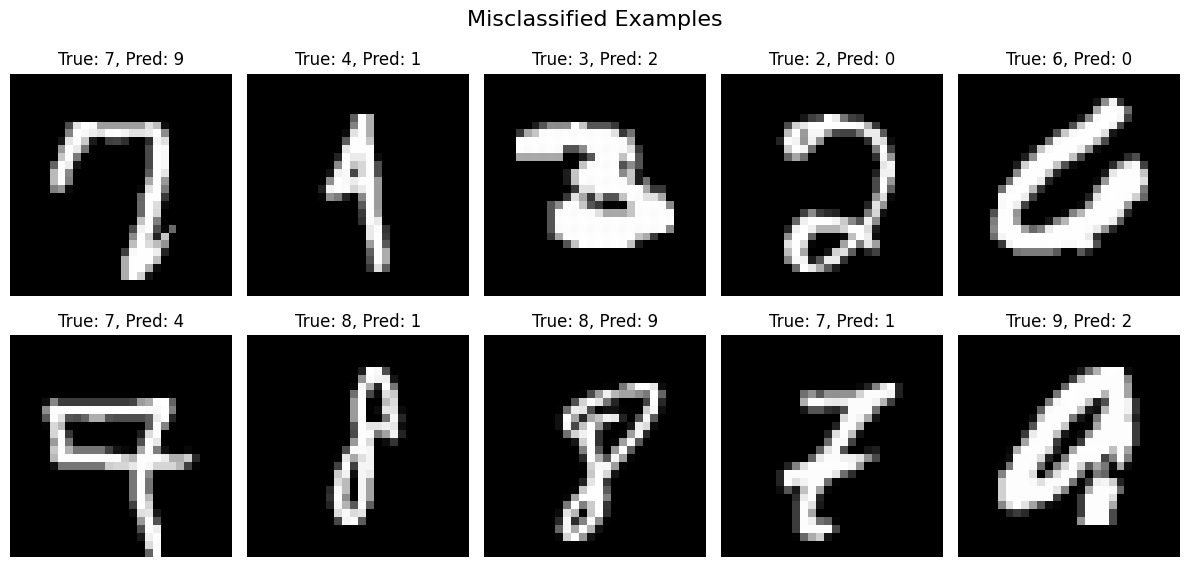

In [154]:
# find misclassified examples
misclassified_indices = np.where(y_test != y_pred)[0]
print(f"Number of misclassified samples: {len(misclassified_indices)} out of {len(y_test)}")
print(f"Error rate: {len(misclassified_indices) /  len(y_test) *100:.2f}%")

# show some misclassified examples
if len(misclassified_indices) > 0:
    fig, axes = plt.subplots(2,5, figsize=(12,6))
    fig.suptitle("Misclassified Examples", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(misclassified_indices) and i < 10:
            idx = misclassified_indices[i]
            # get the test sample index in the original subset
            original_idx = X_test.index[idx] if hasattr(X_test, 'index') else idx

            image = X_test[idx].reshape(28,28)
            ax.imshow(image, cmap='gray')
            ax.set_title(f"True: {y_test[idx]}, Pred: {y_pred[idx]}")
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

## 12. Summary and Conclusion

In [155]:
print("SUMMARY AND CONCLUSIONS")
print(f"Dataset: MNIST (subset of {X_subset.shape[0]} samples)")
print(f"Algorithm: K-Nearest Neighbors")
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Cross-validation accuracy: {grid_search.best_score_:.4f}")
print(f"Test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Goal achievement: {'SUCCESS!' if test_accuracy > 0.97 else 'Close, but not quite there'}")

print("\nKEY INSIGHTS")
print("1. KNN performs excellently on MNIST due to the similarity-based nature of digit recognition")
print("2. Distance weighting typically performs better than uniform weighting")
print("3. Moderate k values (5-11) tend to work best, balancing bias and variance")
print("4. The algorithm is computationally intensive but achieves high accuracy")

print("\nNEXT STEPS FOR IMPROVEMENT")
print("1. Try different distance metrics (e.g., Manhattan distance)")
print("2. Apply dimensionality reduction (PCA) before KNN")
print("3. Use the full dataset instead of a subset")
print("4. Experiment with ensemble methods combining multiple KNN models")

SUMMARY AND CONCLUSIONS
Dataset: MNIST (subset of 50000 samples)
Algorithm: K-Nearest Neighbors
Best hyperparameters: {'n_neighbors': 3, 'weights': 'distance'}
Cross-validation accuracy: 0.9660
Test accuracy: 0.9705 (97.05%)
Goal achievement: SUCCESS!

KEY INSIGHTS
1. KNN performs excellently on MNIST due to the similarity-based nature of digit recognition
2. Distance weighting typically performs better than uniform weighting
3. Moderate k values (5-11) tend to work best, balancing bias and variance
4. The algorithm is computationally intensive but achieves high accuracy

NEXT STEPS FOR IMPROVEMENT
1. Try different distance metrics (e.g., Manhattan distance)
2. Apply dimensionality reduction (PCA) before KNN
3. Use the full dataset instead of a subset
4. Experiment with ensemble methods combining multiple KNN models


## Conclusion
This notebook demonstrated a systematic approach to building a high-performance KNN classifier for MNIST:

**1. Data Loading & Preprocessing:** Proper normalization and exploration

**2.Strategic Sampling:** Using a subset for faster computation while maintaining performance

**3. Hyperparameter Optimization:** Systematic grid search to find optimal parameters

**4. Comprehensive Evaluation:** Multiple metrics and visualizations

**5. Error Analysis:** Understanding model limitations and failure cases


The KNN algorithm proved to be surprisingly effective for digit classification, achieving our target of >97% accuracy through careful hyperparameter tuning. The combination of distance weighting and an appropriate number of neighbors was key to achieving optimal performance.